In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
df = pd.read_csv("team_traditional.csv")
df = df[df["season"] >= 2024].reset_index(drop=True)

# Keep base columns
df = df[[
    "gameid", "date", "team", "home", "away",
    "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%",
    "FTM", "FTA", "FT%", "OREB", "DREB", "REB",
    "AST", "TOV", "STL", "BLK", "PF"
]].copy()

# Home flag
df["is_home"] = (df["team"] == df["home"]).astype(int)

# Split home vs away
home = df[df["is_home"] == 1].copy()
away = df[df["is_home"] == 0].copy()

# Merge into one row per game
games = home.merge(away, on="gameid", suffixes=("_home", "_away"))

# Rename for clarity
games = games.rename(columns={
    "team_home": "home_team",
    "team_away": "away_team",
    "PTS_home": "home_PTS",
    "PTS_away": "away_PTS"
})

# Date + sorting
games["date"] = pd.to_datetime(games["date_home"])
games = games.sort_values("date")

# True Shooting %
games["TS_home"] = games["home_PTS"] / (
    2 * (games["FGA_home"] + 0.44 * games["FTA_home"])
)
games["TS_away"] = games["away_PTS"] / (
    2 * (games["FGA_away"] + 0.44 * games["FTA_away"])
)

# Fix inf / NaN
games["TS_home"].replace([np.inf, -np.inf], np.nan, inplace=True)
games["TS_away"].replace([np.inf, -np.inf], np.nan, inplace=True)
games["TS_home"].fillna(games["TS_home"].mean(), inplace=True)
games["TS_away"].fillna(games["TS_away"].mean(), inplace=True)

# Target variable
games["TOTAL_POINTS"] = games["home_PTS"] + games["away_PTS"]

# Label encode categorical variables
le_home = LabelEncoder()
le_away = LabelEncoder()

games["home_team_enc"] = le_home.fit_transform(games["home_team"])
games["away_team_enc"] = le_away.fit_transform(games["away_team"])

# FINAL FEATURE SET
final_df = games[[
    "gameid", "date",

    # Encoded teams
    "home_team_enc", 
    "away_team_enc",

    # Shooting efficiency & pace
    "TS_home", "TS_away",
    "FGA_home", "FGA_away",

    # Possession/control
    "REB_home", "REB_away",
    "AST_home", "AST_away",
    "TOV_home", "TOV_away",

    # Target
    "home_PTS", "away_PTS",
    "TOTAL_POINTS"
]]

final_df.head(), final_df.shape

(      gameid       date  home_team_enc  away_team_enc   TS_home   TS_away  \
 0   22300061 2023-10-24              7             13  0.617989  0.541498   
 1   22300062 2023-10-24              9             23  0.458878  0.526932   
 13  22300074 2023-10-25             12             24  0.633759  0.552349   
 12  22300073 2023-10-25             26              6  0.602959  0.577346   
 11  22300072 2023-10-25             28             25  0.544725  0.586643   
 
     FGA_home  FGA_away  REB_home  REB_away  AST_home  AST_away  TOV_home  \
 0       91.0      90.0      42.0      44.0      29.0      23.0      12.0   
 1      101.0      95.0      49.0      60.0      19.0      23.0      11.0   
 13      90.0      93.0      45.0      40.0      36.0      20.0      18.0   
 12      89.0      99.0      45.0      48.0      33.0      24.0      19.0   
 11      91.0     102.0      54.0      45.0      22.0      29.0      14.0   
 
     TOV_away  home_PTS  away_PTS  TOTAL_POINTS  
 0       12.0   

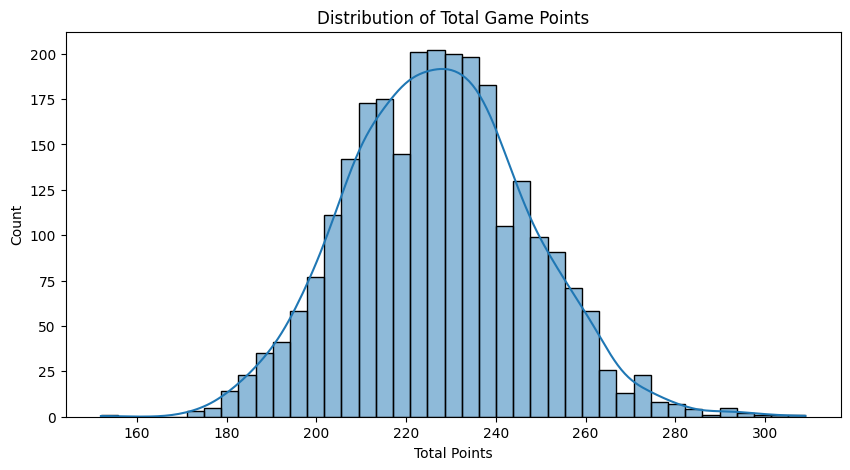

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(final_df["TOTAL_POINTS"], kde=True)
plt.title("Distribution of Total Game Points")
plt.xlabel("Total Points")
plt.show()

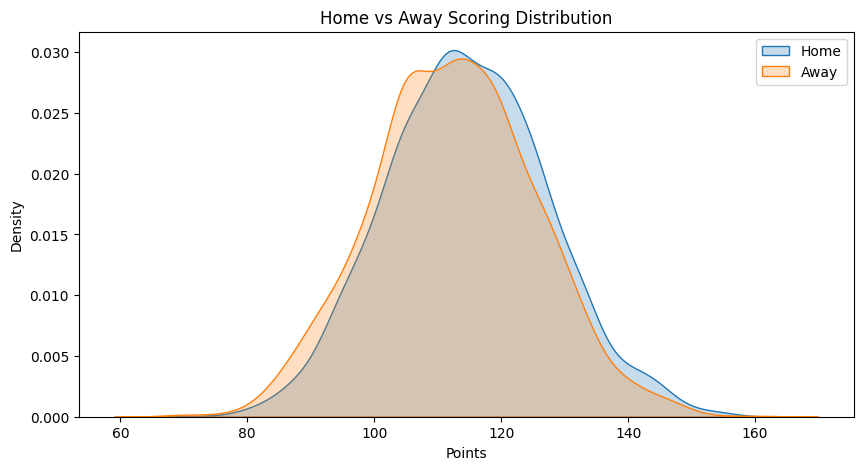

In [17]:
plt.figure(figsize=(10,5))
sns.kdeplot(final_df["home_PTS"], label="Home", fill=True)
sns.kdeplot(final_df["away_PTS"], label="Away", fill=True)
plt.title("Home vs Away Scoring Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

In [20]:
numeric_df = final_df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

reduced_df = final_df.drop(columns=to_drop)

print("Dropped columns:", to_drop)
print("Remaining columns:", reduced_df.columns)

Dropped columns: []
Remaining columns: Index(['gameid', 'date', 'home_team_enc', 'away_team_enc', 'TS_home',
       'TS_away', 'FGA_home', 'FGA_away', 'REB_home', 'REB_away', 'AST_home',
       'AST_away', 'TOV_home', 'TOV_away', 'home_PTS', 'away_PTS',
       'TOTAL_POINTS'],
      dtype='object')


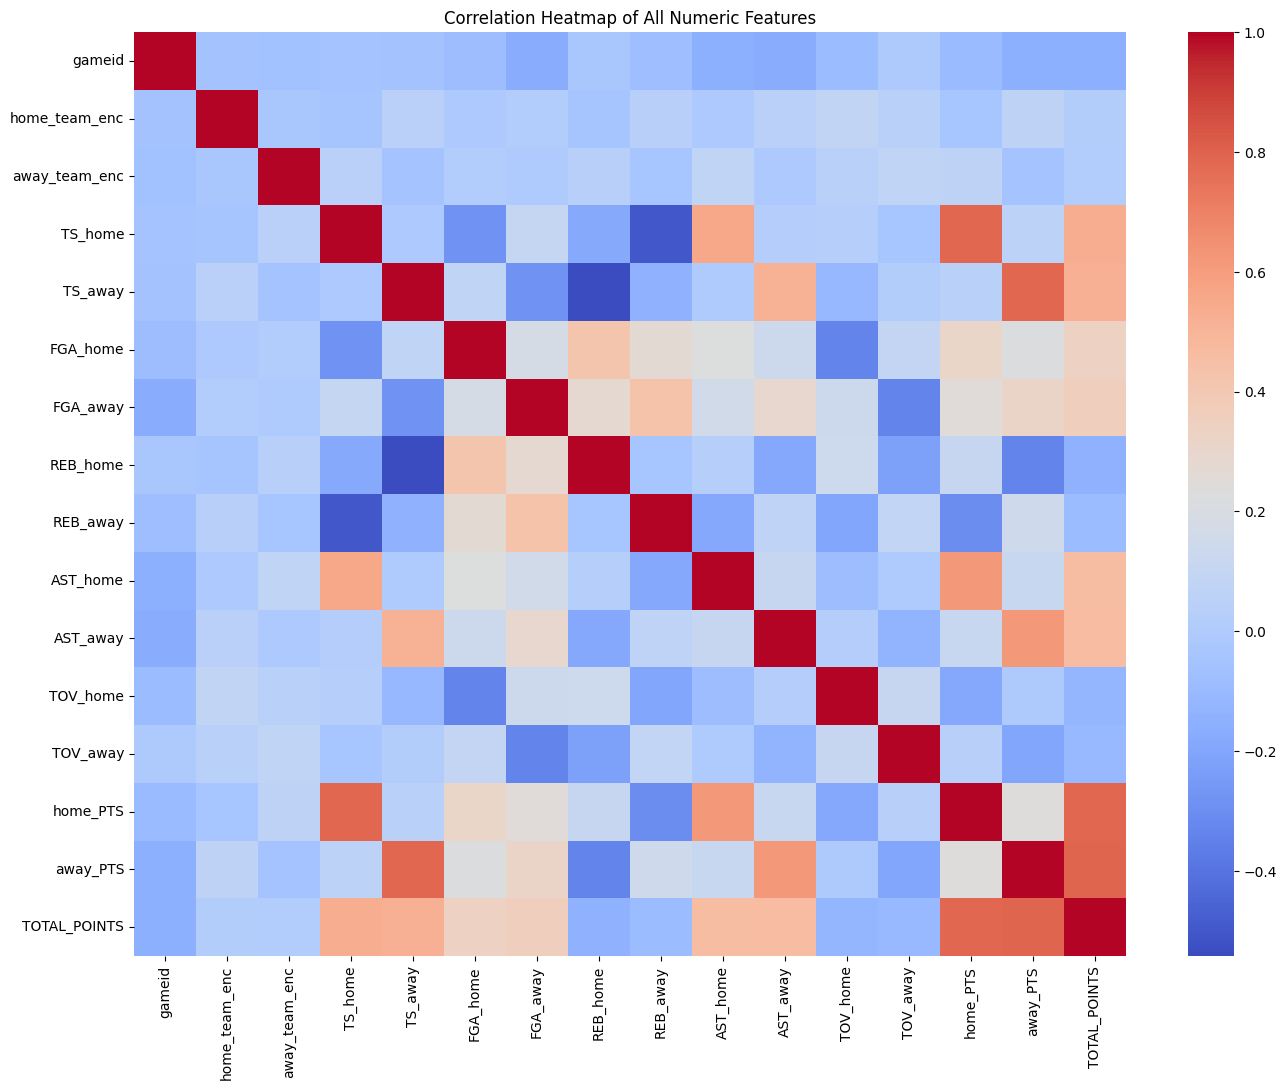

In [19]:
numeric_only = reduced_df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(16, 12))
sns.heatmap(numeric_only.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()